Import Library

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from prophet import Prophet

Time Series Split

In [32]:
def stl_decomposition(
    input_csv_path: str,
    retained_columns: list,
    time_column: str = "date",
    suffix: bool = True
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    
    df = pd.read_csv(input_csv_path, parse_dates=[time_column])
    
    required_cols = [time_column] + retained_columns
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Required column '{col}' not found in DataFrame")
    
    retained_df = df[required_cols].copy()
    decompose_cols = [col for col in df.columns if col not in required_cols]
    
    non_numeric = df[decompose_cols].select_dtypes(exclude='number').columns.tolist()
    if non_numeric:
        raise ValueError(f"Non-numeric columns to decompose: {non_numeric}")
    
    trend = retained_df.copy()
    seasonal = retained_df.copy()
    residual = retained_df.copy()
    
    for col in decompose_cols:
        stl = STL(df[col], 
                period=52, 
                seasonal=15, 
                trend=101, 
                robust=True)
        res = stl.fit()
        
        col_suffix = f"_{col}" if suffix else ""
        trend[f"trend{col_suffix}"] = res.trend
        seasonal[f"seasonal{col_suffix}"] = res.seasonal
        residual[f"resid{col_suffix}"] = res.resid
    
    return trend, seasonal, residual

if __name__ == "__main__":
    csv_files = [
        os.path.join("..", "data", "processed", "sj_past.csv"),
        os.path.join("..", "data", "processed", "sj_future.csv"),
        os.path.join("..", "data", "processed", "iq_past.csv"),
        os.path.join("..", "data", "processed", "iq_future.csv")
    ]
    
    decomposition_results = {}
    
    for csv_file in csv_files:
        base_name = os.path.splitext(csv_file)[0]
        trend_df, seasonal_df, resid_df = stl_decomposition(
            input_csv_path=csv_file,
            retained_columns=["city", "year", "weekofyear"],
            time_column="week_start_date",
            suffix=True
        )
        
        decomposition_results[f"{base_name}_trend"] = trend_df
        decomposition_results[f"{base_name}_seasonal"] = seasonal_df
        decomposition_results[f"{base_name}_resid"] = resid_df

Resid Analysis

In [33]:
sj_resid = decomposition_results["..\\data\\processed\\sj_past_resid"]
iq_resid = decomposition_results["..\\data\\processed\\iq_past_resid"]

sj_target_resid = sj_resid["resid_total_cases"]
iq_target_resid = iq_resid["resid_total_cases"]

# all other residual
sj_predictor_resids = sj_resid[[col for col in sj_resid.columns if col.startswith("resid_")]]
iq_predictor_resids = iq_resid[[col for col in iq_resid.columns if col.startswith("resid_")]]

In [34]:
#sj Pearson
sj_correlations = {}

for col in sj_predictor_resids.columns:
    corr, _ = pearsonr(sj_predictor_resids[col], sj_target_resid)
    sj_correlations[col] = corr

for var, corr in sj_correlations.items():
    print(f"{var}: {corr:.4f}")

resid_ndvi_ne: -0.0261
resid_ndvi_nw: 0.0024
resid_ndvi_se: -0.0064
resid_ndvi_sw: 0.0041
resid_reanalysis_air_temp_k: 0.0273
resid_reanalysis_avg_temp_k: 0.0216
resid_reanalysis_max_air_temp_k: 0.0582
resid_reanalysis_min_air_temp_k: 0.0187
resid_reanalysis_precip_amt_kg_per_m2: 0.0166
resid_reanalysis_relative_humidity_percent: 0.0138
resid_reanalysis_sat_precip_amt_mm: -0.0172
resid_reanalysis_tdtr_k: 0.0198
resid_station_avg_temp_c: 0.0373
resid_station_diur_temp_rng_c: -0.0108
resid_station_max_temp_c: 0.0592
resid_station_min_temp_c: 0.0150
resid_station_precip_mm: 0.0091
resid_dew_humidity: -0.0400
resid_total_cases: 1.0000


In [35]:
#iq Pearson
iq_correlations = {}

for col in iq_predictor_resids.columns:
    corr, _ = pearsonr(iq_predictor_resids[col], iq_target_resid)
    iq_correlations[col] = corr

for var, corr in iq_correlations.items():
    print(f"{var}: {corr:.4f}")

resid_ndvi_ne: 0.0213
resid_ndvi_nw: -0.0028
resid_ndvi_se: -0.0244
resid_ndvi_sw: 0.0324
resid_reanalysis_air_temp_k: -0.0709
resid_reanalysis_avg_temp_k: -0.0934
resid_reanalysis_max_air_temp_k: -0.0833
resid_reanalysis_min_air_temp_k: -0.0183
resid_reanalysis_precip_amt_kg_per_m2: 0.0254
resid_reanalysis_relative_humidity_percent: 0.0465
resid_reanalysis_sat_precip_amt_mm: 0.0354
resid_reanalysis_tdtr_k: -0.0647
resid_station_avg_temp_c: -0.0492
resid_station_diur_temp_rng_c: -0.0428
resid_station_max_temp_c: -0.0308
resid_station_min_temp_c: 0.0160
resid_station_precip_mm: 0.0008
resid_dew_humidity: 0.0207
resid_total_cases: 1.0000


In [36]:
sj_corr_df = pd.DataFrame(sj_correlations.items(), columns=["variable", "correlation"])
sj_corr_df["correlation"] = sj_corr_df["correlation"].round(5)
sj_corr_df = sj_corr_df.sort_values(by="correlation", ascending=False)

iq_corr_df = pd.DataFrame(iq_correlations.items(), columns=["variable", "correlation"])
iq_corr_df["correlation"] = iq_corr_df["correlation"].round(5)
iq_corr_df = iq_corr_df.sort_values(by="correlation", ascending=False)

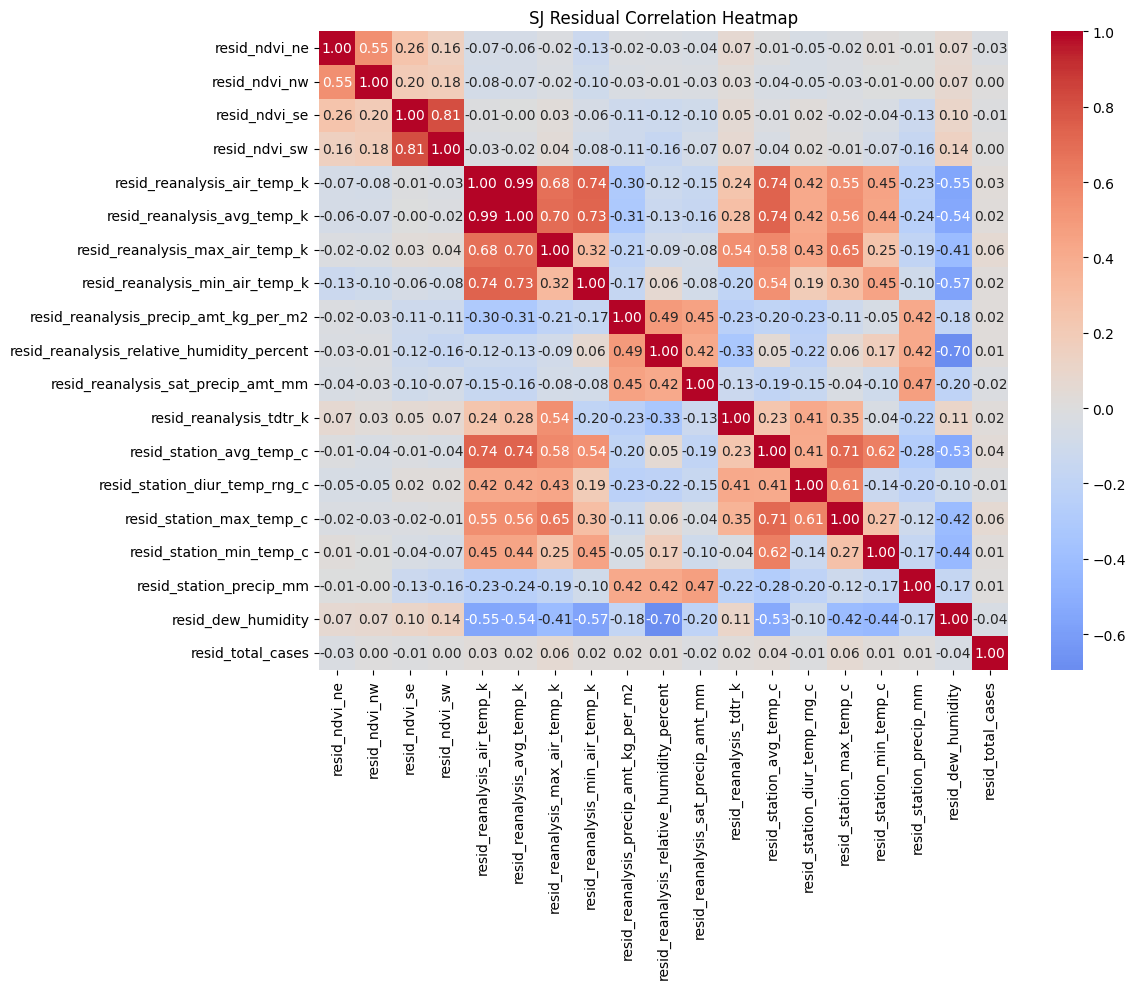

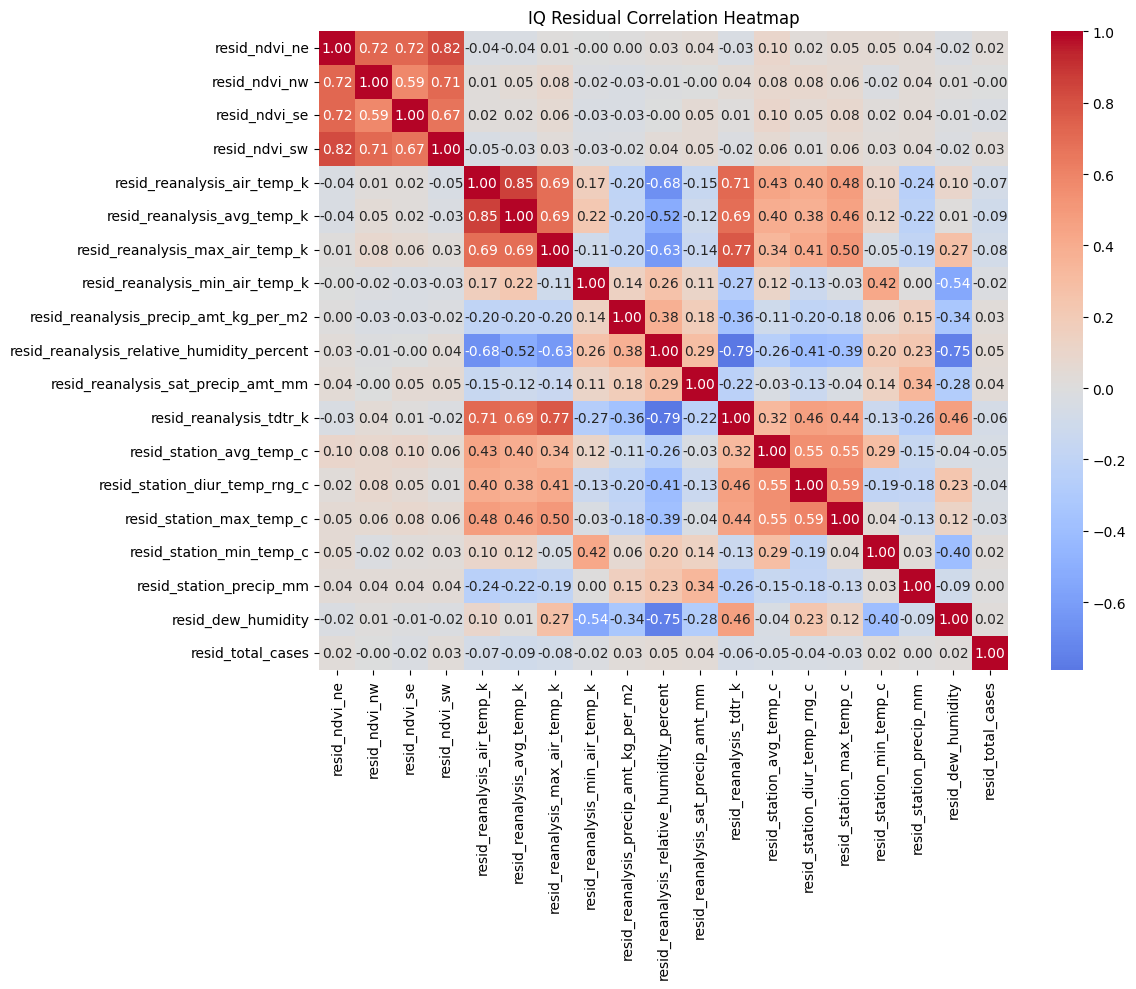

In [37]:
#sj Heatmap
plt.figure(figsize=(12, 10))
sj_corr_matrix = sj_resid[[col for col in sj_resid.columns if col.startswith("resid_")]].corr()
sns.heatmap(sj_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("SJ Residual Correlation Heatmap")
plt.tight_layout()
plt.show()

#iq Heatmap
plt.figure(figsize=(12, 10))
iq_corr_matrix = iq_resid[[col for col in iq_resid.columns if col.startswith("resid_")]].corr()
sns.heatmap(iq_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("IQ Residual Correlation Heatmap")
plt.tight_layout()
plt.show()

Seasonal Analysis

In [38]:
sj_seasonal = decomposition_results["..\\data\\processed\\sj_past_seasonal"]
iq_seasonal = decomposition_results["..\\data\\processed\\iq_past_seasonal"]

sj_target_seasonal = sj_seasonal["seasonal_total_cases"]
iq_target_seasonal= iq_seasonal["seasonal_total_cases"]

# all other seasonal
sj_predictor_seasonal = sj_seasonal[[col for col in sj_seasonal.columns if col.startswith("seasonal_")]]
iq_predictor_seasonal = iq_seasonal[[col for col in iq_seasonal.columns if col.startswith("seasonal_")]]

In [39]:
#sj Pearson
sj_correlations = {}

for col in sj_predictor_seasonal.columns:
    corr, _ = pearsonr(sj_predictor_seasonal[col], sj_target_seasonal)
    sj_correlations[col] = corr

for var, corr in sj_correlations.items():
    print(f"{var}: {corr:.4f}")

seasonal_ndvi_ne: 0.0393
seasonal_ndvi_nw: -0.0051
seasonal_ndvi_se: 0.1630
seasonal_ndvi_sw: -0.0122
seasonal_reanalysis_air_temp_k: 0.3514
seasonal_reanalysis_avg_temp_k: 0.3441
seasonal_reanalysis_max_air_temp_k: 0.3167
seasonal_reanalysis_min_air_temp_k: 0.3644
seasonal_reanalysis_precip_amt_kg_per_m2: 0.2755
seasonal_reanalysis_relative_humidity_percent: 0.2022
seasonal_reanalysis_sat_precip_amt_mm: 0.2243
seasonal_reanalysis_tdtr_k: -0.2880
seasonal_station_avg_temp_c: 0.1628
seasonal_station_diur_temp_rng_c: -0.0748
seasonal_station_max_temp_c: 0.0455
seasonal_station_min_temp_c: 0.2004
seasonal_station_precip_mm: 0.2145
seasonal_dew_humidity: -0.3503
seasonal_total_cases: 1.0000


In [40]:
#iq Pearson
iq_correlations = {}

for col in iq_predictor_seasonal.columns:
    corr, _ = pearsonr(iq_predictor_seasonal[col], iq_target_seasonal)
    iq_correlations[col] = corr

for var, corr in iq_correlations.items():
    print(f"{var}: {corr:.4f}")

seasonal_ndvi_ne: -0.1304
seasonal_ndvi_nw: -0.1661
seasonal_ndvi_se: -0.1691
seasonal_ndvi_sw: -0.1653
seasonal_reanalysis_air_temp_k: 0.1319
seasonal_reanalysis_avg_temp_k: 0.1183
seasonal_reanalysis_max_air_temp_k: -0.0718
seasonal_reanalysis_min_air_temp_k: 0.3522
seasonal_reanalysis_precip_amt_kg_per_m2: 0.3074
seasonal_reanalysis_relative_humidity_percent: 0.1945
seasonal_reanalysis_sat_precip_amt_mm: 0.2474
seasonal_reanalysis_tdtr_k: -0.1865
seasonal_station_avg_temp_c: 0.1316
seasonal_station_diur_temp_rng_c: -0.0891
seasonal_station_max_temp_c: 0.0074
seasonal_station_min_temp_c: 0.2973
seasonal_station_precip_mm: 0.1959
seasonal_dew_humidity: -0.2804
seasonal_total_cases: 1.0000


In [41]:
sj_corr_df = pd.DataFrame(sj_correlations.items(), columns=["variable", "correlation"])
sj_corr_df["correlation"] = sj_corr_df["correlation"].round(5)
sj_corr_df = sj_corr_df.sort_values(by="correlation", ascending=False)

iq_corr_df = pd.DataFrame(iq_correlations.items(), columns=["variable", "correlation"])
iq_corr_df["correlation"] = iq_corr_df["correlation"].round(5)
iq_corr_df = iq_corr_df.sort_values(by="correlation", ascending=False)

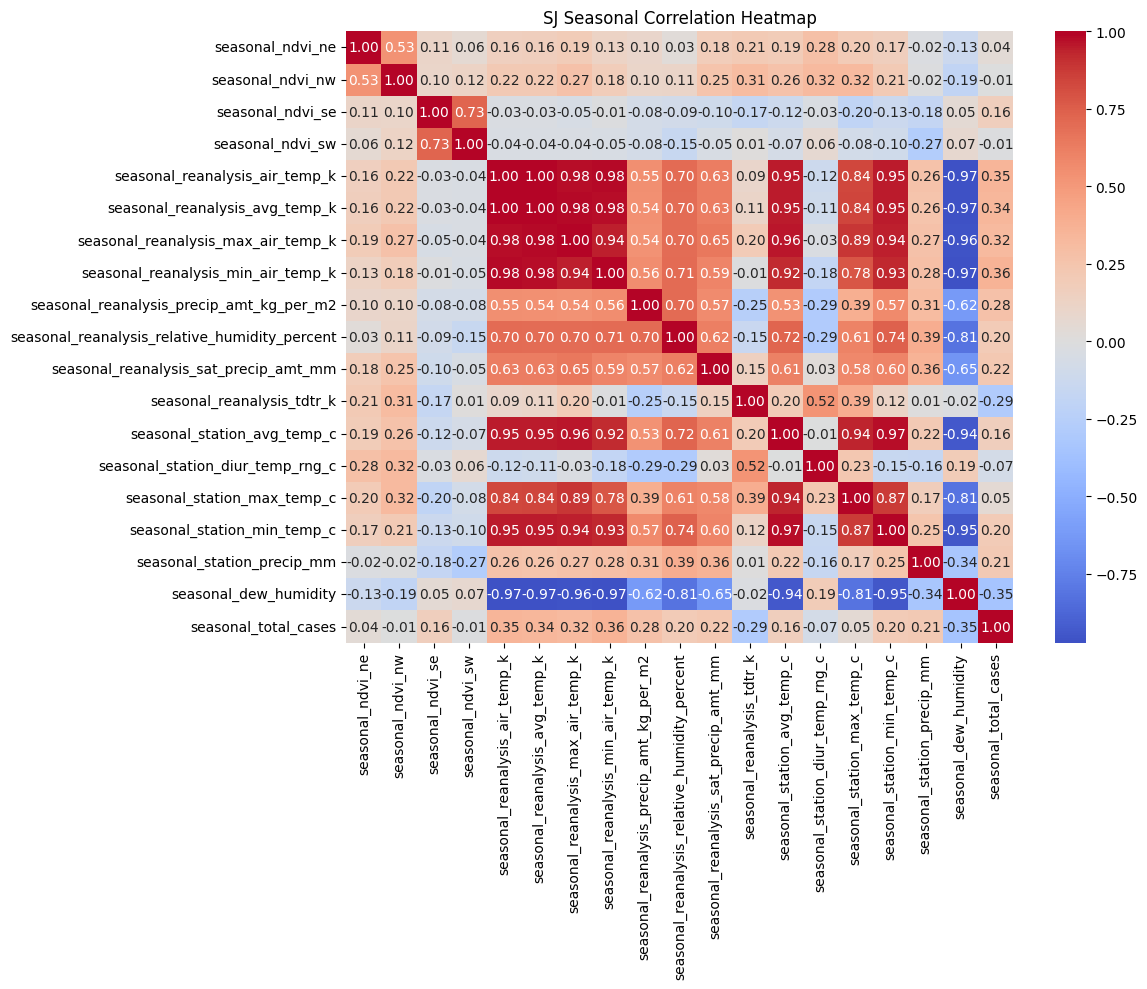

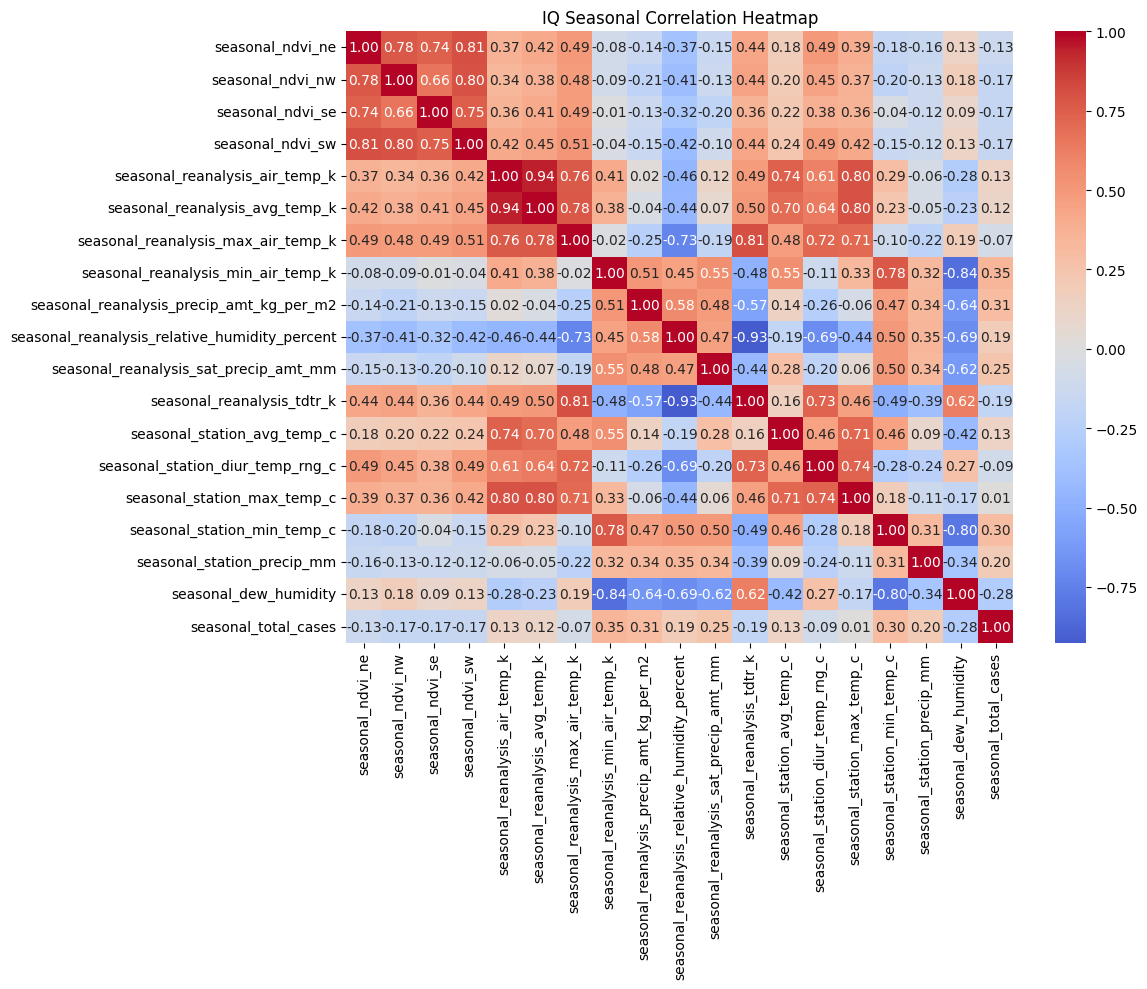

In [42]:
#sj Heatmap
plt.figure(figsize=(12, 10))
sj_corr_matrix = sj_seasonal[[col for col in sj_seasonal.columns if col.startswith("seasonal_")]].corr()
sns.heatmap(sj_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("SJ Seasonal Correlation Heatmap")
plt.tight_layout()
plt.show()

#iq Heatmap
plt.figure(figsize=(12, 10))
iq_corr_matrix = iq_seasonal[[col for col in iq_seasonal.columns if col.startswith("seasonal_")]].corr()
sns.heatmap(iq_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("IQ Seasonal Correlation Heatmap")
plt.tight_layout()
plt.show()

Trend Analysis

In [43]:
sj_trend = decomposition_results["..\\data\\processed\\sj_past_trend"]
iq_trend = decomposition_results["..\\data\\processed\\iq_past_trend"]

sj_target_trend = sj_trend["trend_total_cases"]
iq_target_trend= iq_trend["trend_total_cases"]

# all other trend
sj_predictor_trend = sj_trend[[col for col in sj_trend.columns if col.startswith("trend_")]]
iq_predictor_trend = iq_trend[[col for col in iq_trend.columns if col.startswith("trend_")]]

In [44]:
#sj Pearson
sj_correlations = {}

for col in sj_predictor_trend.columns:
    corr, _ = pearsonr(sj_predictor_trend[col], sj_target_trend)
    sj_correlations[col] = corr

for var, corr in sj_correlations.items():
    print(f"{var}: {corr:.4f}")

trend_ndvi_ne: 0.4156
trend_ndvi_nw: 0.4468
trend_ndvi_se: -0.2565
trend_ndvi_sw: -0.0752
trend_reanalysis_air_temp_k: -0.4896
trend_reanalysis_avg_temp_k: -0.4948
trend_reanalysis_max_air_temp_k: -0.4000
trend_reanalysis_min_air_temp_k: -0.3505
trend_reanalysis_precip_amt_kg_per_m2: 0.6794
trend_reanalysis_relative_humidity_percent: 0.6456
trend_reanalysis_sat_precip_amt_mm: -0.2195
trend_reanalysis_tdtr_k: -0.6115
trend_station_avg_temp_c: 0.2657
trend_station_diur_temp_rng_c: 0.3106
trend_station_max_temp_c: 0.4087
trend_station_min_temp_c: 0.0065
trend_station_precip_mm: -0.4443
trend_dew_humidity: 0.0920
trend_total_cases: 1.0000


In [45]:
#iq Pearson
iq_correlations = {}

for col in iq_predictor_trend.columns:
    corr, _ = pearsonr(iq_predictor_trend[col], iq_target_trend)
    iq_correlations[col] = corr

for var, corr in iq_correlations.items():
    print(f"{var}: {corr:.4f}")

trend_ndvi_ne: 0.1618
trend_ndvi_nw: 0.2942
trend_ndvi_se: -0.3178
trend_ndvi_sw: 0.2737
trend_reanalysis_air_temp_k: 0.5713
trend_reanalysis_avg_temp_k: 0.1421
trend_reanalysis_max_air_temp_k: -0.1698
trend_reanalysis_min_air_temp_k: 0.8216
trend_reanalysis_precip_amt_kg_per_m2: 0.4742
trend_reanalysis_relative_humidity_percent: 0.7001
trend_reanalysis_sat_precip_amt_mm: 0.2777
trend_reanalysis_tdtr_k: -0.5867
trend_station_avg_temp_c: 0.5294
trend_station_diur_temp_rng_c: -0.3651
trend_station_max_temp_c: 0.0922
trend_station_min_temp_c: 0.5725
trend_station_precip_mm: -0.1542
trend_dew_humidity: -0.9060
trend_total_cases: 1.0000


In [46]:
sj_corr_df = pd.DataFrame(sj_correlations.items(), columns=["variable", "correlation"])
sj_corr_df["correlation"] = sj_corr_df["correlation"].round(5)
sj_corr_df = sj_corr_df.sort_values(by="correlation", ascending=False)

iq_corr_df = pd.DataFrame(iq_correlations.items(), columns=["variable", "correlation"])
iq_corr_df["correlation"] = iq_corr_df["correlation"].round(5)
iq_corr_df = iq_corr_df.sort_values(by="correlation", ascending=False)

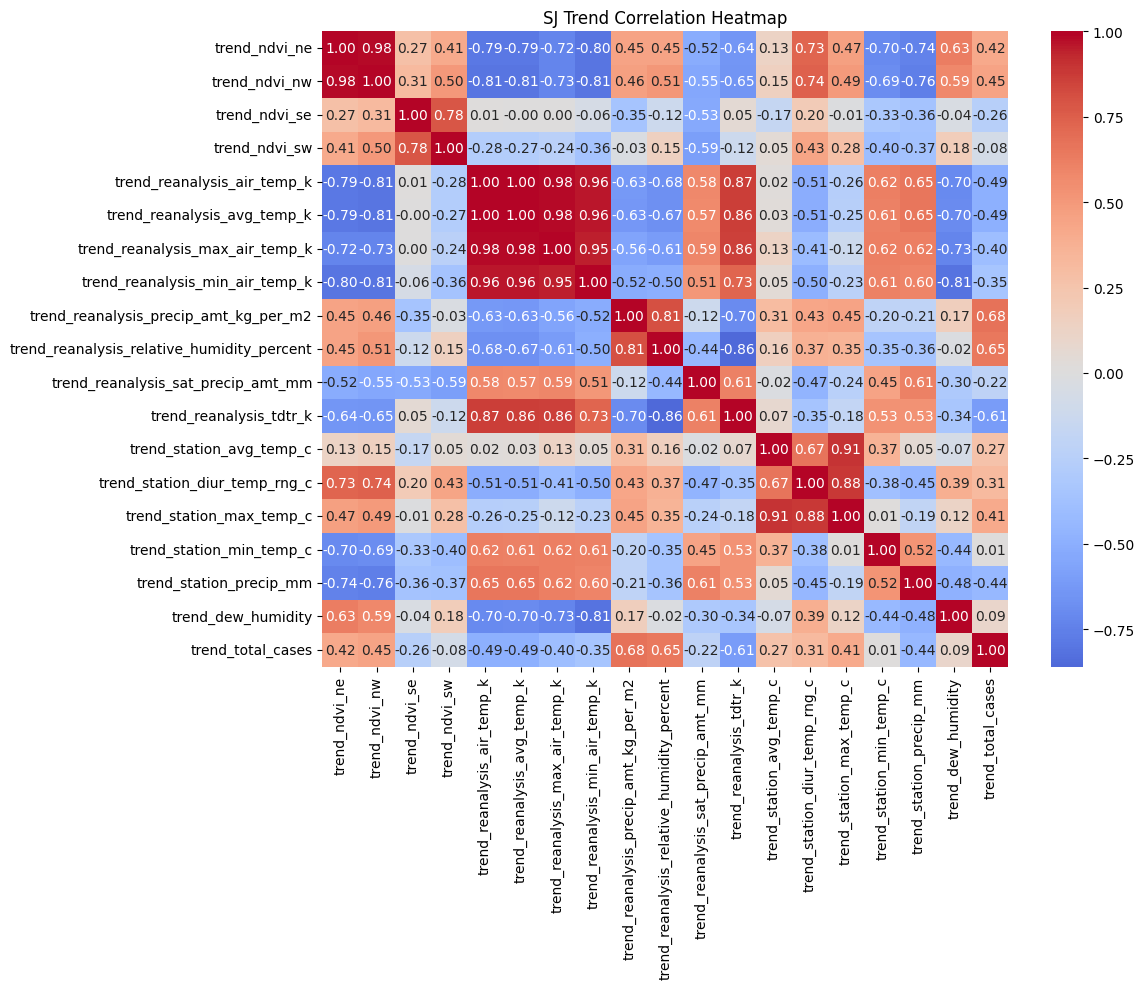

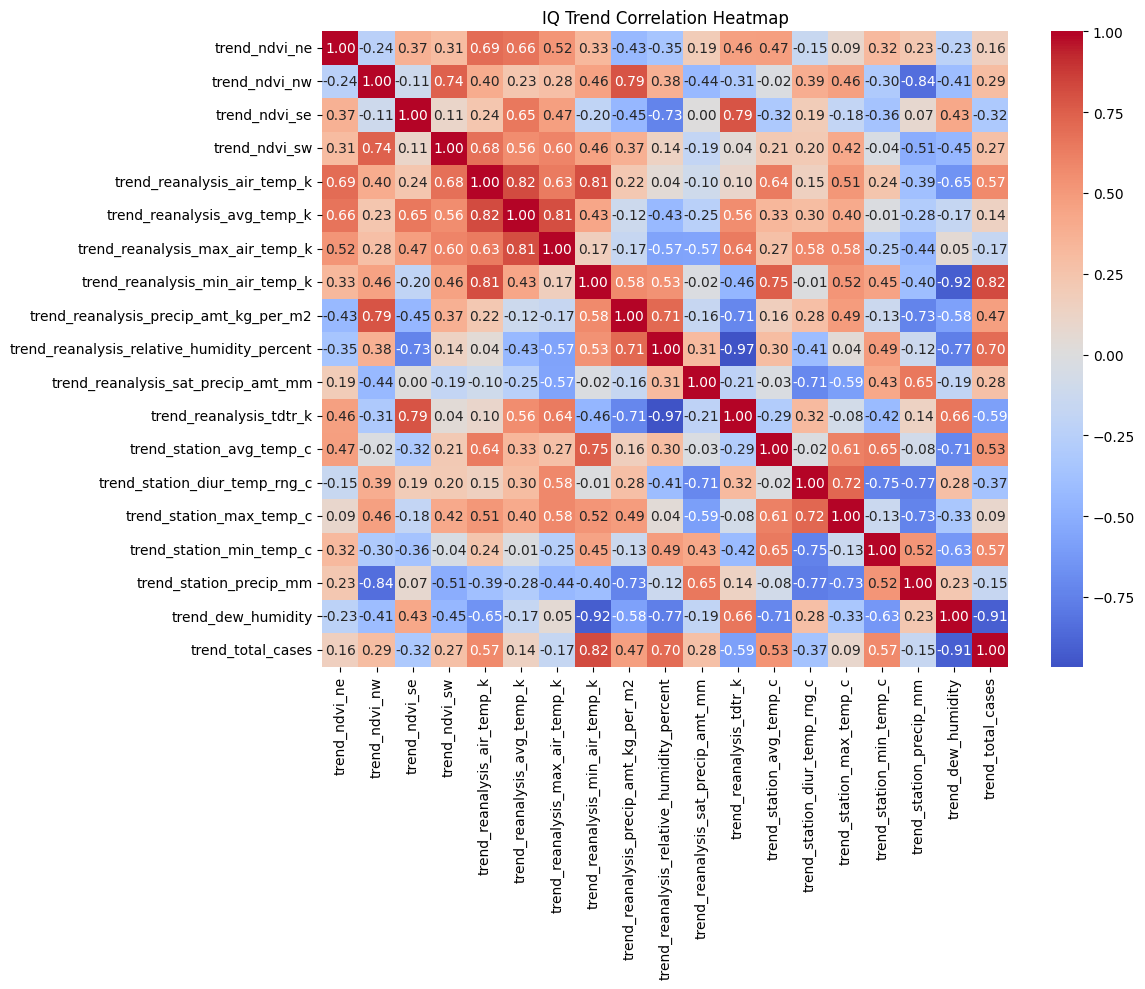

In [47]:
#sj Heatmap
plt.figure(figsize=(12, 10))
sj_corr_matrix = sj_trend[[col for col in sj_trend.columns if col.startswith("trend_")]].corr()
sns.heatmap(sj_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("SJ Trend Correlation Heatmap")
plt.tight_layout()
plt.show()

#iq Heatmap
plt.figure(figsize=(12, 10))
iq_corr_matrix = iq_trend[[col for col in iq_trend.columns if col.startswith("trend_")]].corr()
sns.heatmap(iq_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("IQ Trend Correlation Heatmap")
plt.tight_layout()
plt.show()

Prophet

In [3]:
features = [
    'ndvi_ne', 'ndvi_nw', 'station_diur_temp_rng_c',
    'station_avg_temp_c', 'ndvi_se', 'ndvi_sw',
    'station_precip_mm', 'station_max_temp_c',
    'station_min_temp_c', 'reanalysis_sat_precip_amt_mm',
    'reanalysis_relative_humidity_percent', 'reanalysis_tdtr_k',
    'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
    'reanalysis_max_air_temp_k', 'reanalysis_avg_temp_k',
    'reanalysis_air_temp_k', 'dew_humidity'
]

Time Series For SJ

16:10:16 - cmdstanpy - INFO - Chain [1] start processing
16:10:16 - cmdstanpy - INFO - Chain [1] done processing


Validation MAE = 26.11


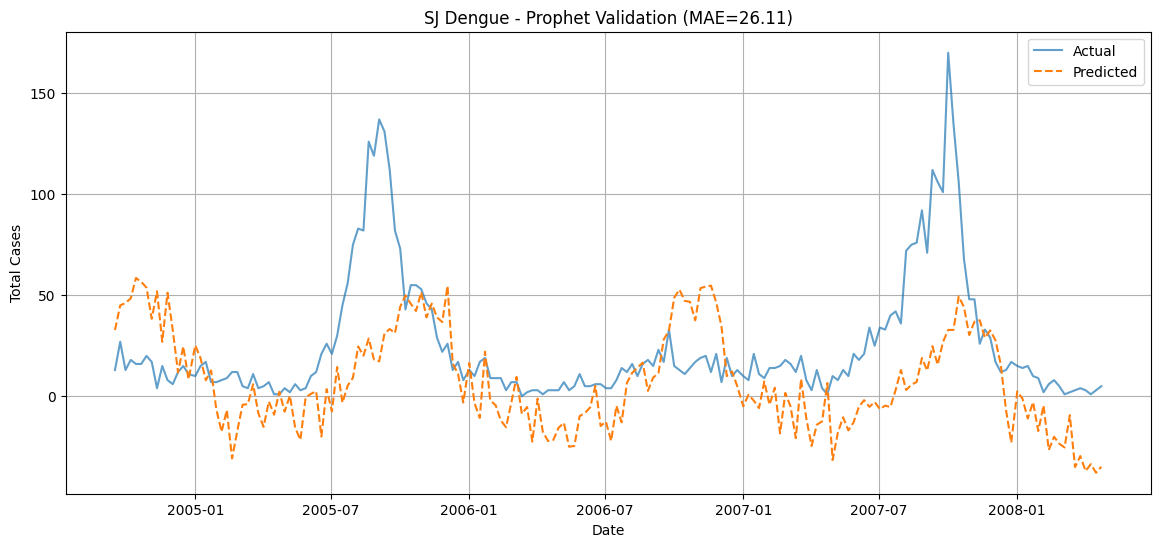

In [4]:
sj_train_data_path = os.path.join("..", "data", "processed", "sj_past.csv")
sj_df = pd.read_csv(sj_train_data_path, parse_dates=["week_start_date"])
sj_df = sj_df.rename(columns={
    "week_start_date": "ds",
    "total_cases":     "y"
})

sj_scaler = MinMaxScaler(feature_range=(0,1))
sj_df[features] = sj_scaler.fit_transform(sj_df[features])

sj_split   = int(len(sj_df) * 0.8)
sj_train_df = sj_df.iloc[:sj_split].reset_index(drop=True)
sj_val_df   = sj_df.iloc[sj_split:].reset_index(drop=True)

sj_m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)
for feat in features:
    sj_m.add_regressor(feat)

sj_m.fit(sj_train_df)

sj_forecast_val = sj_m.predict(sj_val_df)
sj_y_true = sj_val_df["y"].values
sj_y_pred = sj_forecast_val["yhat"].values
mae = mean_absolute_error(sj_y_true, sj_y_pred)
print(f"Validation MAE = {mae:.2f}")

plt.figure(figsize=(14,6))
plt.plot(sj_val_df["ds"], sj_y_true, label="Actual", alpha=0.7)
plt.plot(sj_val_df["ds"], sj_y_pred, label="Predicted", linestyle="--")
plt.title(f"SJ Dengue - Prophet Validation (MAE={mae:.2f})")
plt.xlabel("Date")
plt.ylabel("Total Cases")
plt.legend()
plt.grid(True)
plt.show()

16:11:50 - cmdstanpy - INFO - Chain [1] start processing
16:11:50 - cmdstanpy - INFO - Chain [1] done processing


Validation MAE = 7.21


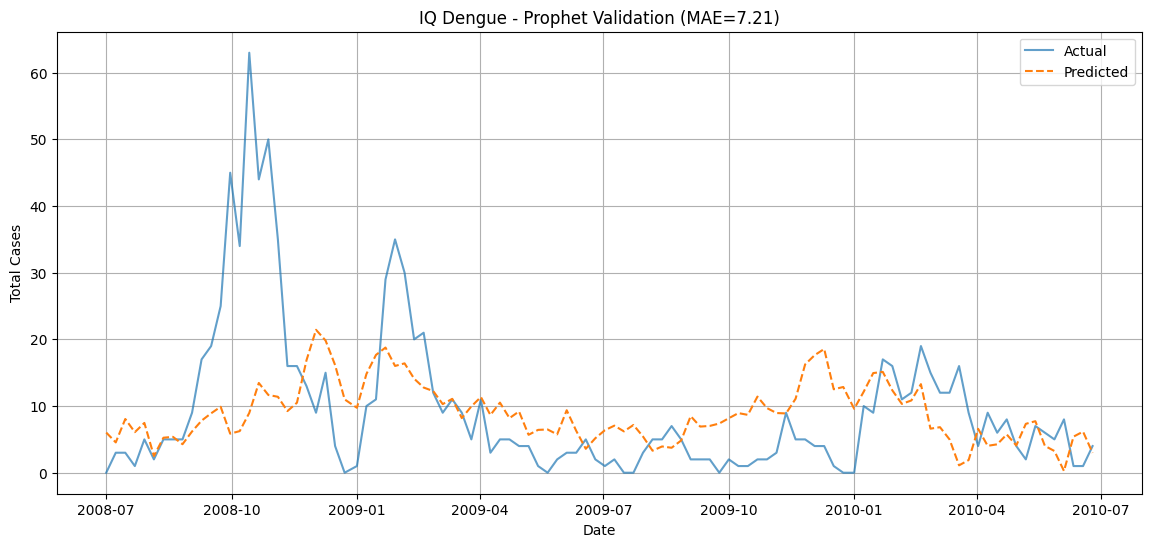

In [5]:
iq_train_data_path = os.path.join("..", "data", "processed", "iq_past.csv")
iq_df = pd.read_csv(iq_train_data_path, parse_dates=["week_start_date"])
iq_df = iq_df.rename(columns={
    "week_start_date": "ds",
    "total_cases":     "y"
})

iq_scaler = MinMaxScaler(feature_range=(0,1))
iq_df[features] = iq_scaler.fit_transform(iq_df[features])

iq_split   = int(len(iq_df) * 0.8)
iq_train_df = iq_df.iloc[:iq_split].reset_index(drop=True)
iq_val_df   = iq_df.iloc[iq_split:].reset_index(drop=True)

iq_m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)
for feat in features:
    iq_m.add_regressor(feat)

iq_m.fit(iq_train_df)

iq_forecast_val = iq_m.predict(iq_val_df)
iq_y_true = iq_val_df["y"].values
iq_y_pred = iq_forecast_val["yhat"].values
mae = mean_absolute_error(iq_y_true, iq_y_pred)
print(f"Validation MAE = {mae:.2f}")

plt.figure(figsize=(14,6))
plt.plot(iq_val_df["ds"], iq_y_true, label="Actual", alpha=0.7)
plt.plot(iq_val_df["ds"], iq_y_pred, label="Predicted", linestyle="--")
plt.title(f"IQ Dengue - Prophet Validation (MAE={mae:.2f})")
plt.xlabel("Date")
plt.ylabel("Total Cases")
plt.legend()
plt.grid(True)
plt.show()